In [1]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten,Dense

2024-03-01 18:41:45.355964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 18:41:45.356063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 18:41:45.493043: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
batch_size=32

In [3]:
train_datagen=ImageDataGenerator(
    
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
   

)
test_datagen=ImageDataGenerator()


In [4]:
train_gen=train_datagen.flow_from_directory(
    "/kaggle/input/melanoma-cancer-dataset/train",
    target_size=(224,224),
    shuffle=False,
    batch_size=batch_size,
     color_mode="rgb",
    class_mode="binary",
)


Found 11879 images belonging to 2 classes.


In [5]:
test_gen=test_datagen.flow_from_directory(
    "/kaggle/input/melanoma-cancer-dataset/test",
    target_size=(224,224),
    shuffle=False,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    

)

Found 2000 images belonging to 2 classes.


In [6]:
base_model=EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224,224,3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
for layer in base_model.layers:
    layer.trainable=False

In [8]:
model = keras.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
METRICS = [
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),
]

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=[keras.losses.BinaryCrossentropy(from_logits=False)],
    metrics=METRICS,
)

In [10]:
model.fit(train_gen,epochs=5,steps_per_epoch=len(train_gen.classes)//batch_size,validation_data=test_gen)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/371 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.4453 - auc: 0.0000e+00 - loss: 9.9789 - precision: 0.0000e+00 - recall: 0.0000e+00   

I0000 00:00:1709318579.828010      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1709318579.885682      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


259/371 ━━━━━━━━━━━━━━━━━━━━ 1:21 728ms/step - accuracy: 0.6647 - auc: 0.6958 - loss: 2.3879 - precision: 0.6367 - recall: 0.5858

W0000 00:00:1709318767.582309      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


370/371 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.6733 - auc: 0.7144 - loss: 1.9822 - precision: 0.6612 - recall: 0.5797

W0000 00:00:1709318842.575365      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


371/371 ━━━━━━━━━━━━━━━━━━━━ 334s 772ms/step - accuracy: 0.6734 - auc: 0.7146 - loss: 1.9767 - precision: 0.6616 - recall: 0.5796 - val_accuracy: 0.8170 - val_auc: 0.9409 - val_loss: 0.3661 - val_precision: 0.9215 - val_recall: 0.6930
Epoch 2/5
  1/371 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.8750 - auc: 0.0000e+00 - loss: 0.8839 - precision: 0.0000e+00 - recall: 0.0000e+00

W0000 00:00:1709318865.581286      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8750 - auc: 0.0000e+00 - loss: 0.8839 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8085 - val_auc: 0.9400 - val_loss: 0.3720 - val_precision: 0.9255 - val_recall: 0.6710
Epoch 3/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 165s 436ms/step - accuracy: 0.7351 - auc: 0.7852 - loss: 0.5578 - precision: 0.8568 - recall: 0.4996 - val_accuracy: 0.7245 - val_auc: 0.8140 - val_loss: 0.5251 - val_precision: 0.9228 - val_recall: 0.4900
Epoch 4/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9062 - auc: 0.0000e+00 - loss: 1.1446 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7275 - val_auc: 0.8138 - val_loss: 0.5247 - val_precision: 0.9252 - val_recall: 0.4950
Epoch 5/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 166s 440ms/step - accuracy: 0.7574 - auc: 0.8174 - loss: 0.5282 - precision: 0.8895 - recall: 0.5555 - val_accuracy: 0.7240 - val_auc: 0.9188 - val_loss: 0.4206 - val_precision: 0.9375 - val_recall: 0.4800


 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step

W0000 00:00:1709319213.661523      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step


W0000 00:00:1709319222.843522      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


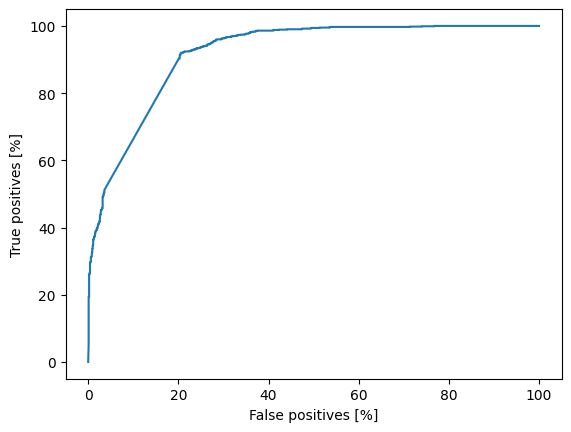

63/63 - 3s - 53ms/step - accuracy: 0.7240 - auc: 0.9188 - loss: 0.4206 - precision: 0.9375 - recall: 0.4800


[0.420556902885437,
 0.7239999771118164,
 0.9188253879547119,
 0.9375,
 0.47999998927116394]

In [11]:
import numpy as np
import math
from sklearn.metrics import roc_curve
def plot_roc(labels, data):
    predictions = model.predict(data)
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100 * fp, 100 * tp)
    plt.xlabel("False positives [%]")
    plt.ylabel("True positives [%]")
    plt.show()


test_labels = np.array([])
num_batches = 0

for _, y in test_gen:
    test_labels = np.append(test_labels, y)
    num_batches += 1
    if num_batches == math.ceil(len(test_gen.classes) / batch_size):
        break

plot_roc(test_labels, test_gen)
model.evaluate(test_gen, verbose=2)